# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='assets/XY_season_images.png' width=80% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='assets/horse2zebra.jpg' width=50% />

### CycleGAN and Exercises Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

To successfully train a cycle gan, we need to do the following: 

>1. **You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory.** 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models. 
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.* 
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [1]:
# loading in and transforming data
from typing import Callable
import os

import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize 

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

import multiprocessing

num_cores = multiprocessing.cpu_count()

%matplotlib inline

Number of CPU cores: 16


In [2]:
def get_data_loader(image_type: str, 
                    transform: Callable,
                    image_dir: str = 'summer2winter_yosemite', 
                    batch_size: int = 16, 
                    num_workers: int = 0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    #### 
    # IMPLEMENT HERE
    ####
    path = image_dir+image_type
    dataset = datasets.ImageFolder(root=path, transform=transform)
    
    # split into train and test datasets
    train_size = int(0.8*(len(dataset)))
    test_size = len(dataset)-train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    # create dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

In [3]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data

# resize and normalize the images
image_size = 128
transform = Compose([Resize(image_size), # resize to 128x128
                     ToTensor(),
#                      Normalize(
#                          [0.5 for _ in range(3)], 
#                          [0.5 for _ in range(3)]
#                      ),
                    ],
                   )
    
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer', 
                                                  transform=transform,
                                                  image_dir='summer2winter_yosemite/',
                                                  num_workers=num_cores)
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter', 
                                                  transform=transform,
                                                  image_dir='summer2winter_yosemite/',
                                                  num_workers=num_cores)

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

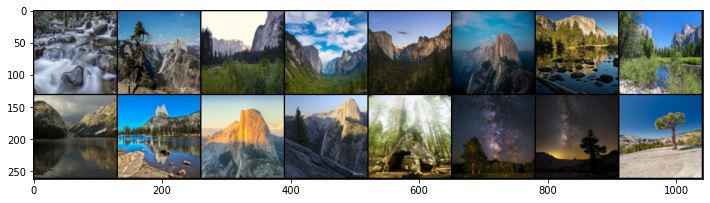

In [4]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

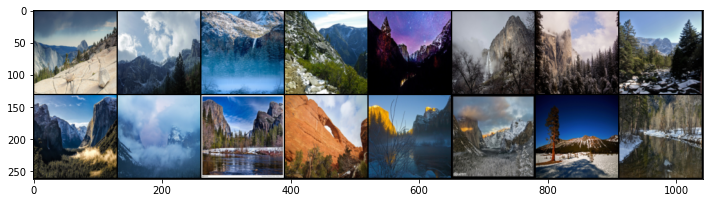

In [5]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.) 

This time, try to use the [`Normalize` transform](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html) to output values directly between -1 and 1. 

In [39]:
transforms = Compose([
                        ToTensor(),
                        Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                    ])

In [40]:
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer', 
                                                  transform=transforms,
                                                  image_dir='summer2winter_yosemite/',)
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter', 
                                                  transform=transforms,
                                                  image_dir='summer2winter_yosemite/',)

In [41]:
for image, _ in dataloader_X:
    print(f'Image min: {image.min()}, Image max: {image.max()}')
    break

Image min: -1.0, Image max: 1.0


In [42]:
for image, _ in dataloader_Y:
    print(f'Image min: {image.min()}, Image max: {image.max()}')
    break

Image min: -1.0, Image max: 1.0
